# CapFloor Sensitivities

This second notebook in the Cap & Floor SDK series builds upon the Fundamentals Template and demonstrates advanced **sensitivities analysis** within the **LSEG Financial Analytics SDK**. 


**You will be able to:**
- Define Cap/Floor instruments with basic parameters 
- Price and evaluate Cap/Floor sensitivities
- Analyze Cap/Floor & Caplets/Floorlets sensitivities
- Visualize Cap/Floor sensitivities values for comprehensive risk analysis


## Imports


Import the following necessary modules:

- `lseg_analytics.pricing.instruments.cap_floor` - for CapFloor instruments definitions and analytics

This notebook uses external libraries **pandas, IPython, matplotlib**; please ensure they are installed in your Python environment (e.g. 'pip install pandas') before running the code.

In [1]:
from lseg_analytics.pricing.instruments import cap_floor as cf

import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from IPython.display import display

## Data Preparation

To define a Cap/Floor instrument you need to follow a structured 3-step process:

1. **CapFloor Definition** - Specify basic cap/floor parameters (strike, dates, notional, index)
2. **CapFloor Instrument Definition** - Create the instrument object
3. **Pricing Preferences** - Configure pricing parameters, optional


In [2]:
# 1. Define the cap instrument
cap_definition = cf.IPACapFloorDefinition(
    buy_sell = cf.IPABuySellEnum.BUY.value,                                   # Buy cap protection
    cap_strike_percent = 2.0,                                                 # 2% strike rate
    start_date = dt.datetime.strptime("2025-01-01", "%Y-%m-%d"),              # Start date
    end_date = dt.datetime.strptime("2030-01-01", "%Y-%m-%d"),                # Maturity date
    notional_amount = 1_000_000,                                              # $1M notional
    notional_ccy = "USD",                                                     # USD currency
    index_name = "SOFR",                                                      # SOFR index
    index_tenor = "ON",
    interest_payment_frequency = cf.IndexResetFrequencyEnum.QUARTERLY.value,  # Quarterly payments
)

cap_instrument = cf.IPACapFloorDefinitionInstrument(definition = cap_definition)
print("Instrument definition created")

# 2. Configure pricing parameters
pricing_params = cf.CapFloorPricingParameters(
    valuation_date = dt.datetime.strptime("2025-07-18", "%Y-%m-%d"),                
)
print("Pricing parameters configured")

Instrument definition created
Pricing parameters configured


## Request Execution

In [3]:
#  Execute the calculation using the price() function
# The 'definitions' parameter accepts a list of instruments definitions for batch processing

response = cf.price(
    definitions = [cap_instrument],
    pricing_preferences = pricing_params
)

print("Pricing execution completed")


Pricing execution completed


## Results Display

#### Key Sections in the `response` JSON

 - **definitions**: Instrument setup (e.g., strike, dates, notional, index), it's IPACapFloorDefinition that we used. 

 - **pricingPreferences**: Valuation date, price side, currency, skip first caplet.

 - **analytics**:
   - **tabularData**: `data`, `headers`, `statuses`
   - **cashflows**: Includes arrays and detailed `cashFlows` (payments, fixings)
   - **description**: Instrument summary IPACapFloorDefinition and also the default fields not specified in the IPACapFloorDefinition, but used by default in the calculation
   - **greeks**: Sensitivities to market movement at Cap/Floor and Caplet/Floolet levels
   - **pricingAnalysis**: `atmStrikePercent`, `impliedVolatilityPercent`, `spreadEquivalentBp`
   - **valuation**: `marketValueInDealCcy`, `premiumPercent`, `premiumBp`
   - **error**: provides the root cause of the issue, if any

#### Cap/Floor Greeks

In [4]:
# Extract Greeks from the response
greeks = response.data.analytics[0].greeks

# Extract Cap/Floor level Greeks directly (non-array values)
cap_greeks_data = {greek: value for greek, value in greeks.items() if not isinstance(value, list)}

# Convert the dictionary to a DataFrame
df_cap_greeks = pd.DataFrame(list(cap_greeks_data.items()), columns=["Greeks", "Value"])

# Display the DataFrame with Cap/Floor level Greeks
display(df_cap_greeks) 

,Greeks,Value
0,dv01AmountInDealCcy,318.871934
1,deltaPercent,0.773428
2,forwardDeltaPercent,0.837187
3,gammaAmountInDealCcy,0.383259
4,thetaAmountInDealCcy,-20.376115
5,vegaAmountInDealCcy,154.284213


#### Individual Cap/Floor Greeks

In [5]:
print("DV01 (Deal Currency):", greeks.dv01_amount_in_deal_ccy)
print("Delta (%):", greeks.delta_percent)
print("Vega (Deal Currency):", greeks.vega_amount_in_deal_ccy)

DV01 (Deal Currency): 318.871934047274
Delta (%): 0.7734285
Vega (Deal Currency): 154.28421267


#### Caplets/Floorlets Greeks

In [6]:
# Extract caplets Greeks directly from response and create DataFrame
caplets_data = {greek: values for greek, values in greeks.items() if isinstance(values, list)}
df_caplets_greeks = pd.DataFrame(caplets_data)

# Caplets Greeks DataFrame
display(df_caplets_greeks)

,capletsForwardDeltaPercentArray,capletsDv01AmountsInDealCcyArray,capletsGammaAmountsInDealCcyArray,capletsThetaAmountsInDealCcyArray,capletsVegaAmountsInDealCcyArray
0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.999999,18.596098,-0.002506,-0.854932,0.000034
3,0.998417,23.945002,-0.002245,-0.863964,0.088065
4,0.981392,22.276735,0.006409,-0.922286,0.917651
5,0.939590,21.589500,0.020059,-1.108842,2.845413
6,0.881728,20.288456,0.032012,-1.245772,5.302386
7,0.833569,19.584533,0.038222,-1.327694,7.547262
8,0.805428,17.127784,0.035442,-1.208659,8.157892
9,0.790663,17.353469,0.035311,-1.240191,9.468949


#### Cap/Floor Greeks Visualization 

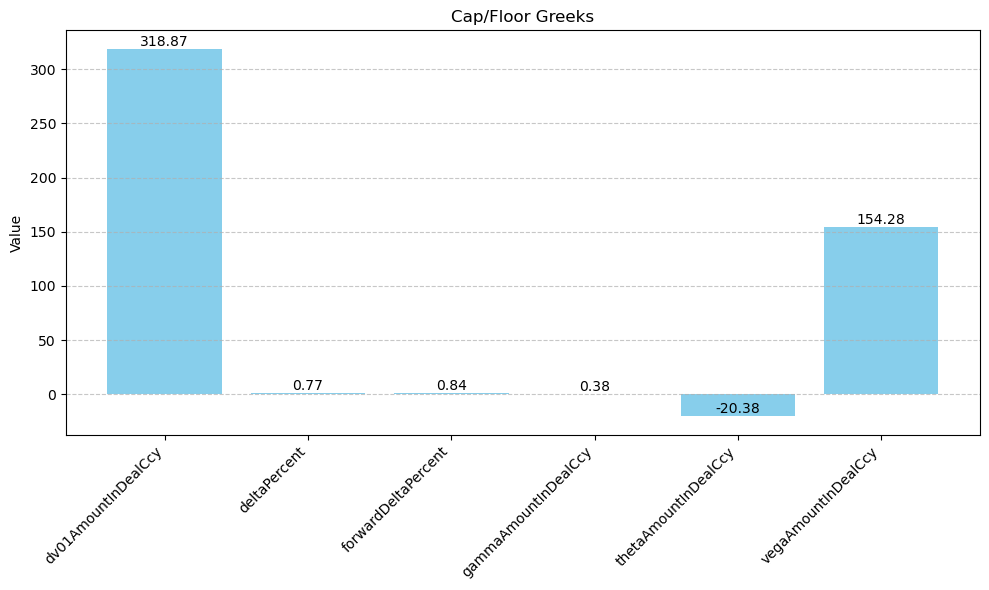

In [7]:
# Create figure with specified size
plt.figure(figsize=(10, 6))

# Create bar plot for each Greek value
bars = plt.bar(df_cap_greeks.index, df_cap_greeks["Value"], color='skyblue', align='center')

# Set chart title and labels
plt.title("Cap/Floor Greeks")
plt.ylabel("Value")

# Set x-axis to show Greek names with rotation for readability
plt.xticks(ticks=df_cap_greeks.index, labels=df_cap_greeks["Greeks"], rotation=45, ha='right')

# Add grid lines for better value reading
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', ha='center', va='bottom')

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()
